<a href="https://colab.research.google.com/github/Pilo1961/QuestionAnswer_System/blob/master/code/question_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Preguntas y Respuestas
## Métodos Analíticos

In [0]:
import numpy as np
import pandas as pd
import json

## Lectura de datos

In [0]:
#load data from google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
path= "/content/drive/My Drive/data/QA/train-v2.0.json"
train=pd.read_json(path,orient='columns')
#path= "/content/drive/My Drive/data/QA/dev-v2.0.json"
#test=pd.read_json(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Datos

Los datos los leemos en un archivo json anidado de varios nivles. La estructura del archivo es la siguiente

+ Titulo
+ Paragraph 
    + Context
    + Qas
        + Id
        + Question
        + Answers
            + Text
            + Answer start
        + Is impossible
        + Plausible answers
            + Text
            + Answer start
  

En las siguientes celdas observamos los diferentes niveles de anidacióón de los datos.

Los datos contienen 130319 preguntas divididas en dos grandes ramas. Preguntas que tienen respuesta y preguntas que no tienen respuestas.


In [0]:
# Lectura de datos
with open(path) as f: 
    d = json.load(f) 

test = pd.json_normalize(d['data'])  
test.shape
test.head()

,title,paragraphs
0,Beyoncé,[{'qas': [{'question': 'When did Beyonce start...
1,Frédéric_Chopin,"[{'qas': [{'question': ""What was Frédéric's na..."
2,Sino-Tibetan_relations_during_the_Ming_dynasty,[{'qas': [{'question': 'Who were Wang Jiawei a...
3,IPod,[{'qas': [{'question': 'Which company produces...
4,The_Legend_of_Zelda:_Twilight_Princess,[{'qas': [{'question': 'What category of game ...


El dataset de entrenamiento es un json anidado. En el primer nivel tiene una columna con el tíítulo y otra columna de json anidado llamada paragreaphs.

In [0]:
nycphil2=pd.json_normalize(data=d['data'],record_path=['paragraphs'],meta=['title'])
nycphil2.head()

,qas,context,title
0,[{'question': 'When did Beyonce start becoming...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,Beyoncé
1,"[{'question': 'After her second solo album, wh...",Following the disbandment of Destiny's Child i...,Beyoncé
2,"[{'question': 'In her music, what are some rec...","A self-described ""modern-day feminist"", Beyonc...",Beyoncé
3,[{'question': 'Beyonce's younger sibling also ...,"Beyoncé Giselle Knowles was born in Houston, T...",Beyoncé
4,[{'question': 'What town did Beyonce go to sch...,Beyoncé attended St. Mary's Elementary School ...,Beyoncé


Si abrimos paragraph tiene dos columnas:
  + qas - json anidado
  + context - Escrito con el contexto de la pregunta
  + title la obtenemos del nivel anterior

In [0]:
nycphil3=pd.json_normalize(data=d['data'],record_path=['paragraphs','qas'])#,meta=['title',['paragraph','context']])
nycphil3.head()

,question,id,answers,is_impossible,plausible_answers
0,When did Beyonce start becoming popular?,56be85543aeaaa14008c9063,"[{'text': 'in the late 1990s', 'answer_start':...",False,NaN
1,What areas did Beyonce compete in when she was...,56be85543aeaaa14008c9065,"[{'text': 'singing and dancing', 'answer_start...",False,NaN
2,When did Beyonce leave Destiny's Child and bec...,56be85543aeaaa14008c9066,"[{'text': '2003', 'answer_start': 526}]",False,NaN
3,In what city and state did Beyonce grow up?,56bf6b0f3aeaaa14008c9601,"[{'text': 'Houston, Texas', 'answer_start': 166}]",False,NaN
4,In which decade did Beyonce become famous?,56bf6b0f3aeaaa14008c9602,"[{'text': 'late 1990s', 'answer_start': 276}]",False,NaN


In [0]:
Al abrir la columna qas encontramos 5 columnas mas
 + Question
 + Id
 + Answers - que es un json anidado
 + is_impossible - con valores booleanos
 + plausible answers - Con NaN y los valores que tiene son json anidados


In [0]:
nycphil3=pd.json_normalize(data=d['data'],record_path=['paragraphs','qas','answers'])#,meta=['title',['paragraph','context']])
nycphil3.head()

,text,answer_start
0,in the late 1990s,269
1,singing and dancing,207
2,2003,526
3,"Houston, Texas",166
4,late 1990s,276


Cuando abrimos la columna answer encontramos dos columnas:
  + Text - texto que contiene la respuesta
  + Answer_start - Posicion de el contexto en el que comienza la respuesta

In [0]:
nycphil3=pd.json_normalize(data=d['data'],record_path=['paragraphs','qas'])#,'plausible_answers'])#,meta=['title',['paragraph','context']])
nycphil3.shape

(130319, 5)

# Preguntas con respuesta
Compilamos el dataframe llamado **df**.
* Contiene 7 columnas y todas las preguntas que cumplen las premisas.
* Contiene 86821 preguntas con respuesta dentreo del set de entrenamiento.
* No tiene valores nulos
* La **variable respuesta** es text, que contiene la respuesta a la pregunta y **answer start** que indica la posicion donde esta la respuesta dentro del contexto.
* La variable is_impossible no tiene variabilidad en preguntas con respuesta

In [0]:
df=pd.json_normalize(data=d['data'],
                        record_path=['paragraphs','qas','answers'],
                        record_prefix=None,
                        meta_prefix=None,
                        meta=['title',
                              ['paragraph','context'],
                              ['paragraph','qas','question'],
                              ['paragraph','qas','id'],
                              ['paragraph','qas','is_impossible']])

df.rename(columns={'paragraph.context':'context','paragraph.qas.question':'question','paragraph.qas.id':'id','paragraph.qas.is_impossible':'is_impossible'},inplace=True)
df.head()

,text,answer_start,title,context,question,id,is_impossible
0,in the late 1990s,269,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,56be85543aeaaa14008c9063,False
1,singing and dancing,207,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,56be85543aeaaa14008c9065,False
2,2003,526,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,56be85543aeaaa14008c9066,False
3,"Houston, Texas",166,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,56bf6b0f3aeaaa14008c9601,False
4,late 1990s,276,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,56bf6b0f3aeaaa14008c9602,False


In [0]:
print("dimensiones df",df.shape)
print("Respuestas imposibles ", df["paragraph.qas.is_impossible"].sum())
print("Nas \n", df.isna().sum())


dimensiones df (86821, 7)
Respuestas imposibles  0
Nas 
 text                           0
answer_start                   0
title                          0
paragraph.context              0
paragraph.qas.question         0
paragraph.qas.id               0
paragraph.qas.is_impossible    0
dtype: int64


## Preguntas sin respuestas
La variable is_impossible boolanea representa las preguntas que no tienen respuesta que se deben de idetificar como parte de la versióón 2 de la base de datos.
Por el momento las vamos a ignorar, sin embargo se en las siguientes casillas se explora un poco la naturaleza de esos datos.
1. En los casos en los que plausible answers tiene valores distintos de Na la variable answer es vacía.
2. En los casos que la variable is_impossilbe tiene valores verdaderos la variable plausible_answers tiene valores distintos de NA.
3. Hay 43498 entradas en esta situacion.

In [0]:
df2=pd.json_normalize(data=d['data'],record_path=['paragraphs','qas'])
df2=df2[df2["is_impossible"]==True]
df2

,question,id,answers,is_impossible,plausible_answers
2075,What category of game is Legend of Zelda: Aust...,5a8d7bf7df8bba001a0f9ab1,[],True,"[{'text': 'action-adventure', 'answer_start': ..."
2076,What consoles can be used to play Australia Tw...,5a8d7bf7df8bba001a0f9ab2,[],True,"[{'text': 'GameCube and Wii', 'answer_start': ..."
2077,When was Australia Twilight launched in North ...,5a8d7bf7df8bba001a0f9ab3,[],True,"[{'text': 'November 2006', 'answer_start': 569}]"
2078,When could GameCube owners purchase Australian...,5a8d7bf7df8bba001a0f9ab4,[],True,"[{'text': 'November 2006', 'answer_start': 569}]"
2079,What year was the Legend of Zelda: Australian ...,5a8d7bf7df8bba001a0f9ab5,[],True,"[{'text': '2005', 'answer_start': 364}]"
...,...,...,...,...,...
130314,Physics has broadly agreed on the definition o...,5a7e070b70df9f001a875439,[],True,"[{'text': 'matter', 'answer_start': 485}]"
130315,Who coined the term partonic matter?,5a7e070b70df9f001a87543a,[],True,"[{'text': 'Alfvén', 'answer_start': 327}]"
130316,What is another name for anti-matter?,5a7e070b70df9f001a87543b,[],True,"[{'text': 'Gk. common matter', 'answer_start':..."
130317,Matter usually does not need to be used in con...,5a7e070b70df9f001a87543c,[],True,"[{'text': 'a specifying modifier', 'answer_sta..."


In [0]:
# Todavio no lo saco pero no es necesario
pd.json_normalize(data=df2['plausible_answers'])

AttributeError: ignored

In [0]:
df2['plausible_answers'].iloc[1]

[{'answer_start': 194, 'text': 'GameCube and Wii'}]


## Dataset version 1


In [0]:
import numpy as np
import pandas as pd
import json

In [162]:
#load data from google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
path= "/content/drive/My Drive/data/QA/train-v1.0.json"
train=pd.read_json(path,orient='columns')
#path= "/content/drive/My Drive/data/QA/dev-v2.0.json"
#test=pd.read_json(path)

Mounted at /content/drive


In [163]:
# Lectura de datos
with open(path) as f: 
    d = json.load(f) 

test = pd.json_normalize(d['data'])  
test.shape
test.head()

,paragraphs,title
0,"[{'context': 'Architecturally, the school has ...",University_of_Notre_Dame
1,[{'context': 'Beyoncé Giselle Knowles-Carter (...,Beyoncé
2,[{'context': 'Montana i/mɒnˈtænə/ is a state i...,Montana
3,"[{'context': 'The phrase ""in whole or in part""...",Genocide
4,[{'context': 'The emergence of resistance of b...,Antibiotics


In [164]:
nycphil2=pd.json_normalize(data=d['data'],record_path=['paragraphs'],meta=['title'])
nycphil2.head()

,context,qas,title
0,"Architecturally, the school has a Catholic cha...","[{'answers': [{'answer_start': 515, 'text': 'S...",University_of_Notre_Dame
1,"As at most other universities, Notre Dame's st...","[{'answers': [{'answer_start': 248, 'text': 'S...",University_of_Notre_Dame
2,The university is the major seat of the Congre...,"[{'answers': [{'answer_start': 119, 'text': 'R...",University_of_Notre_Dame
3,The College of Engineering was established in ...,"[{'answers': [{'answer_start': 487, 'text': 'e...",University_of_Notre_Dame
4,All of Notre Dame's undergraduate students are...,"[{'answers': [{'answer_start': 496, 'text': 'L...",University_of_Notre_Dame


In [165]:
nycphil3=pd.json_normalize(data=d['data'],record_path=['paragraphs','qas'])#,meta=['title',['paragraph','context']])
nycphil3.head()

,answers,id,question
0,"[{'answer_start': 515, 'text': 'Saint Bernadet...",5733be284776f41900661182,To whom did the Virgin Mary allegedly appear i...
1,"[{'answer_start': 187, 'text': ' a copper stat...",5733be284776f4190066117f,What is in front of the Notre Dame Main Building?
2,"[{'answer_start': 279, 'text': 'the Main Build...",5733be284776f41900661180,The Basilica of the Sacred heart at Notre Dame...
3,"[{'answer_start': 381, 'text': 'a Marian place...",5733be284776f41900661181,What is the Grotto at Notre Dame?
4,"[{'answer_start': 92, 'text': 'a golden statue...",5733be284776f4190066117e,What sits on top of the Main Building at Notre...


In [166]:
nycphil3=pd.json_normalize(data=d['data'],record_path=['paragraphs','qas','answers'])#,meta=['title',['paragraph','context']])
nycphil3.head()

,answer_start,text
0,515,Saint Bernadette Soubirous
1,187,a copper statue of Christ
2,279,the Main Building
3,381,a Marian place of prayer and reflection
4,92,a golden statue of the Virgin Mary


In [167]:
df=pd.json_normalize(data=d['data'],
                        record_path=['paragraphs','qas','answers'],
                        record_prefix=None,
                        meta_prefix=None,
                        meta=['title',
                              ['paragraph','context'],
                              ['paragraph','qas','question'],
                              ['paragraph','qas','id']])

df.rename(columns={'paragraph.context':'context','paragraph.qas.question':'question','paragraph.qas.id':'id'},inplace=True)
df.head()

,answer_start,text,title,context,question,id
0,515,Saint Bernadette Soubirous,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,5733be284776f41900661182
1,187,a copper statue of Christ,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,5733be284776f4190066117f
2,279,the Main Building,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,5733be284776f41900661180
3,381,a Marian place of prayer and reflection,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,5733be284776f41900661181
4,92,a golden statue of the Virgin Mary,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,5733be284776f4190066117e


In [168]:
print("dimensiones df",df.shape)
print("Nas \n", df.isna().sum())


dimensiones df (87636, 6)
Nas 
 answer_start    0
text            0
title           0
context         0
question        0
id              0
dtype: int64


# Vocabulario

In [0]:
from textblob import TextBlob
import matplotlib.pyplot as  plt
%matplotlib inline

In [170]:
#creamos una lista con todos los contextos
contextos=df["context"].unique()
len(contextos)

18891

**Text blob** es una paqueteria en python que nos ayuda a procesar lenguaje natural. Tiene muchas funciones para analizar la sintáxis, tokenizar, hacer preprocesamiento, frecuencias, entre otras.

En el contexto de este análisis lo utilizamos para extraer las oraciones de los contextos y para contar las palabras y oraciones que tenemos.

In [0]:
# numero de oraciones por contexto
num_sent=[]
for i in range(len(contextos)):
  num_sent=np.append(num_sent, len(TextBlob(contextos[i]).sentences))

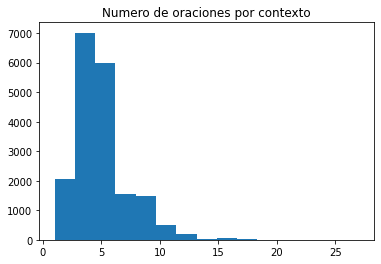

In [172]:
plt.hist(num_sent,bins=15)
plt.title("Numero de oraciones por contexto")
plt.show()

In [173]:
pd.DataFrame(num_sent).describe()

,0
count,18891.000000
mean,4.953470
std,2.326159
min,1.000000
25%,3.000000
50%,5.000000
75%,6.000000
max,27.000000


In [174]:
sentence_corpus= TextBlob(" ".join(contextos)).sentences
len(sentence_corpus)

92659

In [175]:
#Numero de palabras en todos los contextos
corpus= TextBlob(" ".join(contextos)).words
len(corpus)

2220093

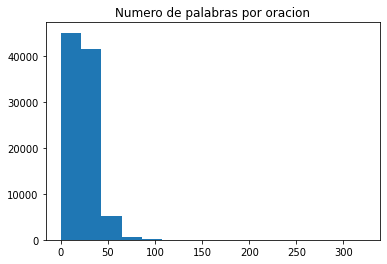

max=  323
min=  0


In [176]:
#palabras por oracion
word_sent=[len(sentence.words) for sentence in sentence_corpus]

plt.hist(word_sent,bins=15)
plt.title("Numero de palabras por oracion")
plt.show()

print("max= ",max(word_sent))
print("min= ",min(word_sent))

## Embedding

Probamos el embedding de [InferSent de Facebook](https://github.com/facebookresearch/InferSent).

Este es un embedding para oraciones completas que provee representaciones semanticas para oraciones en inglés.

In [0]:
import torch
import cython
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec

In [178]:
#Hace el corpus
data=[]
i=0
for cont in contextos: # para cada contexto
  sample=cont
  for sent in sent_tokenize(sample): #Extrae las oraciones
    temp=[]
    for j in word_tokenize(sent): #Estrae las palabras
      temp.append(j.lower())

    data.append(temp)
  i=i+1
  if i%1000==0: print("i= ",i)

i=  1000
i=  2000
i=  3000
i=  4000
i=  5000
i=  6000
i=  7000
i=  8000
i=  9000
i=  10000
i=  11000
i=  12000
i=  13000
i=  14000
i=  15000
i=  16000
i=  17000
i=  18000


In [188]:
#La estructura que queda de data tiene la forma de lista de oraciones.
#Cada oracion es una lista de palabras
#Con este metodo tenemos 93576 oraciones, anteriormente teniamos 92659
#Tiene un 0.1% de variacion
print(len(data))
data[1]

93576


['atop',
 'the',
 'main',
 'building',
 "'s",
 'gold',
 'dome',
 'is',
 'a',
 'golden',
 'statue',
 'of',
 'the',
 'virgin',
 'mary',
 '.']

In [0]:
#entrena un modelo Word2Vec CBOW con nuestro corpus
model1 = gensim.models.Word2Vec(data, min_count = 1,  size = 100, window = 5,workers=8) 

In [180]:
#longitud del vocabulario
len(model1.wv.vocab)

23451

In [208]:
#La representaciones las podemos ver:
model1['building']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([-0.41631997,  0.24322174, -0.26301834,  0.5927479 , -0.43996578,
        0.42519355, -0.8752711 ,  0.8117276 ,  0.57307434,  0.79361266,
        0.6029814 , -0.8874359 , -0.6974811 , -0.342889  ,  0.23446864,
        0.37986547,  0.00337138, -0.86307865, -0.25488955, -1.3216996 ,
       -0.50352377, -0.9396355 , -0.25530764,  0.57404345, -0.30325845,
       -0.3037257 ,  0.7647121 , -1.6702636 ,  0.6862074 ,  0.03333635,
       -0.28773412,  0.7182696 ,  1.703597  ,  0.9000342 ,  0.37890738,
       -1.1757716 ,  0.02837415,  0.12708436, -0.15132459, -0.941572  ,
        1.0221431 ,  0.28083634,  0.25479347,  0.363765  , -0.00975495,
       -0.22245586,  0.6753861 , -0.5523469 , -0.48654947,  0.01129391,
       -0.4954423 ,  0.22348964,  0.22529382,  0.28036055,  0.12528664,
        1.094586  , -1.1631596 , -1.0522741 ,  0.22428045, -0.9672225 ,
       -0.46917588, -1.5162807 , -0.10357415, -0.40197754, -0.04318987,
       -0.21626866,  0.41889626, -0.193274  ,  0.80372745, -0.20

In [192]:
#Buscamos palabras similares a otras
#Una pregunta es:
print("La pregunta 1 es: ")
print(df["question"][1])
print("Palabras similares a building: ")
print(model1.wv.most_similar(positive=['building'], topn=5))
print("Palabras similares a notre: ")
print(model1.wv.most_similar(positive=['notre'], topn=5))
print("Palabras similares a dame: ")
print(model1.wv.most_similar(positive=['dame'], topn=5))
print("Palabras similares a front: ")
print(model1.wv.most_similar(positive=['front'], topn=5))

La pregunta 1 es: 
What is in front of the Notre Dame Main Building?
Palabras similares a building: 
[('centre', 0.8091248273849487), ('street', 0.7997871041297913), ('station', 0.7944681644439697), ('center', 0.7849119901657104), ('park', 0.770930826663971)]
Palabras similares a notre: 
[('dame', 0.9451849460601807), ('yale', 0.868816614151001), ('hospital', 0.8529942035675049), ('chicago', 0.8415922522544861), ('memorial', 0.8412803411483765)]
Palabras similares a dame: 
[('notre', 0.9451850056648254), ('college', 0.8502907156944275), ('hospital', 0.8452717065811157), ('yale', 0.8431522846221924), ('academy', 0.8400453329086304)]
Palabras similares a front: 
[('village', 0.7923232913017273), ('side', 0.7796663045883179), ('town', 0.7559666633605957), ('outskirts', 0.7433922290802002), ('shores', 0.7341602444648743)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
#entrena un modelo Word2Vec skip-gram con nuestro corpus
model2 = gensim.models.Word2Vec(data, min_count = 1, size = 100, window = 5, sg = 1, workers=8)  

In [198]:
#Buscamos palabras similares a otras
#Una pregunta es:
print("La pregunta 1 es: ")
print(df["question"][1])
print("Palabras similares a building: ")
print(model2.wv.most_similar(positive=['building'], topn=5))
print("Palabras similares a notre: ")
print(model2.wv.most_similar(positive=['notre'], topn=5))
print("Palabras similares a dame: ")
print(model2.wv.most_similar(positive=['dame'], topn=5))
print("Palabras similares a front: ")
print(model2.wv.most_similar(positive=['front'], topn=5))

La pregunta 1 es: 
What is in front of the Notre Dame Main Building?
Palabras similares a building: 
[('constructed', 0.8112320303916931), ('subway', 0.8014562129974365), ('buildings', 0.7972802519798279), ('brick', 0.796481728553772), ('civic', 0.7959247827529907)]
Palabras similares a notre: 
[('dame', 0.9711912870407104), ('ku', 0.8672677278518677), ('celebration', 0.8587011098861694), ('athletics', 0.8538817167282104), ('wayne', 0.8535916209220886)]
Palabras similares a dame: 
[('notre', 0.9711912870407104), ('ku', 0.8559335470199585), ('fc', 0.849277138710022), ('athletics', 0.8492733240127563), ('junior', 0.8457870483398438)]
Palabras similares a front: 
[('wing', 0.8303583860397339), ('38th', 0.8075164556503296), ('rear', 0.7912957072257996), ('sides', 0.79121994972229), ('caught', 0.7873533964157104)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Hay que notar que las probabilidades son diferentes para el modelo de CBOW y de skip-grams aunque se entrenaron con el mismo vocabulario.

In [207]:
i=36
q=word_tokenize(df["question"][i].lower())

print("Pregunta:")
print(q)


print("La respuesta indicada es:")
print(df["text"][i])

print("\n")
print("Palabras mas parecidas con CBOW")
print(model1.wv.most_similar(positive=q, topn=6))

print("\n")
print("Palabras mas parecidas con skip-grams")
print(model2.wv.most_similar(positive=q, topn=6))


Pregunta:
['in', 'what', 'year', 'was', 'the', 'theodore', 'm.', 'hesburgh', 'library', 'at', 'notre', 'dame', 'finished', '?']
La respuesta indicada es:
1963


Palabras mas probables con CBOW
[('inaugural', 0.8821373581886292), ('herald', 0.8771012425422668), ('auditorium', 0.8741787672042847), ('jerome', 0.872140645980835), ('allen', 0.8642104864120483), ('princeton', 0.8638155460357666)]


Palabras mas probables con skip-grams
[('peking', 0.9339052438735962), ('honoring', 0.9333432912826538), ('monroeville', 0.9274170994758606), ('ephesus', 0.9249165058135986), ('goddard', 0.9245061874389648), ('bennett', 0.9232707023620605)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Las predicciones que estáá dando el modelo son muy malas. Las palabras mas parecidas no tienen nada que ver con la respuesta a la pregunta.  
Notese que todavia no tenemos ningun entrenamiento en el modelo. Hasta ahora lo unico que tenemos es una representacion matricial de las palabras dado el contexto en el que aparecen en nuestro corpus.   
Sobre esa informacióón debemos contruir un modelo que ligue nuestras representaciones con el sentido de la pregunta.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


KeyError: ignored